<a href="https://colab.research.google.com/github/JeFFich/Data_analysis/blob/Risk-analysis-Tinkoff-Fintech-2024/HW1.LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Управление рисками 2024. Домашнее задание №1.

*Дата выдачи: 06.03.2024*

*Дедлайн: 20.03.2024, 23:59*

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности.

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from typing import Union, Tuple
from scipy.special import logit

### Шаг 0: разбиение на бакеты

In [ ]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [ ]:
# Здесь и далее все функции будем проверять на этом примере

np.random.seed(seed=45)
size = 1000
bin_counts = 10

x = np.random.random(size=size) * 100
target = np.random.randint(2, size=size)
offset = logit(np.mean(target))

In [ ]:
calc_buckets(x,bin_counts)

array([9, 5, 2, 0, 4, 4, 0, 1, 1, 6, 8, 6, 9, 4, 6, 2, 9, 6, 4, 3, 5, 1,
       2, 4, 2, 3, 8, 0, 9, 2, 7, 1, 6, 4, 8, 2, 4, 5, 2, 1, 7, 3, 8, 4,
       1, 8, 7, 1, 8, 0, 1, 1, 9, 6, 2, 2, 9, 6, 4, 0, 4, 2, 3, 6, 7, 4,
       2, 3, 1, 1, 5, 9, 8, 1, 3, 6, 9, 7, 0, 1, 0, 4, 8, 5, 9, 7, 9, 7,
       2, 9, 6, 1, 6, 7, 2, 9, 8, 4, 7, 6, 5, 3, 5, 5, 0, 4, 9, 2, 4, 0,
       9, 4, 0, 0, 0, 3, 1, 1, 2, 4, 0, 3, 1, 3, 7, 8, 9, 1, 5, 4, 9, 6,
       8, 7, 6, 3, 3, 1, 3, 6, 3, 7, 8, 9, 6, 4, 4, 4, 1, 6, 4, 1, 2, 8,
       2, 6, 4, 5, 7, 5, 8, 3, 3, 3, 1, 9, 1, 9, 4, 3, 5, 7, 5, 5, 9, 3,
       1, 8, 8, 6, 9, 5, 3, 0, 9, 9, 4, 7, 2, 9, 0, 0, 1, 6, 8, 1, 4, 9,
       3, 8, 6, 6, 6, 9, 8, 6, 8, 4, 5, 8, 8, 4, 3, 1, 3, 2, 6, 8, 9, 6,
       4, 8, 8, 8, 3, 9, 0, 4, 3, 3, 9, 7, 8, 2, 9, 0, 7, 5, 8, 3, 7, 2,
       9, 6, 8, 5, 3, 5, 7, 7, 4, 3, 7, 8, 0, 2, 6, 6, 2, 5, 2, 0, 7, 5,
       2, 9, 7, 2, 4, 6, 8, 2, 4, 8, 1, 5, 2, 8, 0, 6, 3, 8, 4, 1, 4, 8,
       5, 6, 0, 1, 9, 8, 4, 0, 8, 6, 5, 6, 7, 7, 3,

### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$.

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**:

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big )
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

*Попытка убеждения приведена в **упражнении 2** части 3*

In [ ]:
def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""

    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестировать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [ ]:
first_bucket = target[calc_buckets(x,bin_counts) == 0]

woe_transform(first_bucket.mean(), offset)

0.07629320573272762

Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [ ]:
def get_interval_boundaries(p, n, flag = 0, alpha=0.05):
  """Вычисление левой/правой границы интервала Вальда для badrate"""
  z = sps.norm.ppf(1-alpha/2) # Нужная квантиль
  sts = z * np.sqrt(p * (1 - p) / n) # Статистика для границ интервала
  return max(0, p - sts) if flag == 0 else min(1, p + sts) # Если flag 0, то вернется левая граница, иначе - правая

In [ ]:
def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[np.ndarray]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    # группируем target по bucket и вычисляем badrate (просто среднее по таргету) и количество наблюдений в bucket
    grouped = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['mean', 'count'])['target']
    # векторизованная функция вычисления границ интервала
    vFunc = np.vectorize(get_interval_boundaries)

    # считаем бэдрейт и доверительный интервал для него (любым способом)
    badrate = grouped['mean'].values
    badrate_lower = vFunc(grouped['mean'], grouped['count'], 0)
    badrate_upper = vFunc(grouped['mean'], grouped['count'], 1)

    # переходим от бэдрейта к woe
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper

In [ ]:
np.random.seed(seed=45)
size = 1000
bin_counts = 10

x = np.random.random(size=size) * 100
target = np.random.randint(2, size=size)
offset = logit(np.mean(target))

woe_ci(target, calc_buckets(x,bin_counts), offset)

(array([ 0.07629321, -0.20419376, -0.12405478, -0.00400674, -0.04404411,
        -0.12405478,  0.32141566,  0.07629321, -0.00400674,  0.03609487]),
 array([-0.31581779, -0.60693237, -0.52287269, -0.39828908, -0.4396647 ,
        -0.52287269, -0.06812204, -0.31581779, -0.39828908, -0.35701844]),
 array([0.4812771 , 0.18891955, 0.27156581, 0.39667857, 0.3547738 ,
        0.27156581, 0.74435869, 0.4812771 , 0.39667857, 0.43883348]))

### Шаг 2: расчет линейной интерполяции

In [ ]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    logreg_ = LogisticRegression().fit(np.expand_dims(values, axis=1),target)
    proba = logreg_.predict_proba(np.expand_dims(mean_feature, axis=1))[:, 1]
    line = woe_transform(proba, offset)
    return line

In [ ]:
grouped_mean = pd.DataFrame(data = {'feature':x, 'bucket':calc_buckets(x,bin_counts)}).groupby('bucket')['feature'].mean().values
calc_line(x, target, grouped_mean, offset)

array([-0.0754722 , -0.060643  , -0.04357068, -0.02544039, -0.00952035,
        0.0081625 ,  0.0256425 ,  0.04414102,  0.06161032,  0.07906994])

### Шаг3: собираем результаты по бакетам в один словарь

In [ ]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    # Находим среднее фича по buckets
    grouped_mean = pd.DataFrame(data = {'feature': values, 'bucket': buckets}).groupby('bucket')['feature'].mean().values
    offset = logit(np.mean(target))
    # Вычисляем информацию по woe
    woe_inf = woe_ci(target, buckets, offset)
    buckets_info = {
        "mean_feature" : grouped_mean,
        "line"         : calc_line(values, target, grouped_mean, offset),
        "woe"          : woe_inf[0],
        "woe_lower"    : woe_inf[1],
        "woe_upper"    : woe_inf[2]
    }

    return buckets_info

In [ ]:
calc_buckets_info(x, target, calc_buckets(x, bin_counts))

{'mean_feature': array([ 4.98233532, 13.62201311, 23.56855766, 34.13149374, 43.40670746,
        53.70895917, 63.89302219, 74.67049119, 84.84832348, 95.02051595]),
 'line': array([-0.0754722 , -0.060643  , -0.04357068, -0.02544039, -0.00952035,
         0.0081625 ,  0.0256425 ,  0.04414102,  0.06161032,  0.07906994]),
 'woe': array([ 0.07629321, -0.20419376, -0.12405478, -0.00400674, -0.04404411,
        -0.12405478,  0.32141566,  0.07629321, -0.00400674,  0.03609487]),
 'woe_lower': array([-0.31581779, -0.60693237, -0.52287269, -0.39828908, -0.4396647 ,
        -0.52287269, -0.06812204, -0.31581779, -0.39828908, -0.35701844]),
 'woe_upper': array([0.4812771 , 0.18891955, 0.27156581, 0.39667857, 0.3547738 ,
        0.27156581, 0.74435869, 0.4812771 , 0.39667857, 0.43883348])}

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам.

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

***Ответ:*** *потому что IV позволяет понимать, насколько хорошо признак разделяет наблюдения по классам, даже если при этом ранжируются наблюдения плохо.*

In [ ]:
from sklearn.metrics import roc_auc_score, r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    # ROC-AUC
    auc = roc_auc_score(target, values)

    # Нахождение WoE
    offset = logit(np.mean(target))
    woe, _, _ = woe_ci(target, buckets, offset)

    # Нахождение статистики распределений целевой переменной по buckets и вообще
    buckets_stats = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['sum', 'count'])['target']

    # Статистика для IV
    bad_buckets = buckets_stats['sum']
    good_buckets = buckets_stats['count'] - buckets_stats['sum']
    bad_overall = np.sum(target)
    good_overall = target.shape[0] - bad_overall

    # Непосрдественное вычисление IV
    IV = np.sum((bad_buckets / bad_overall - good_buckets / good_overall) * woe)

    # Взвешенный R^2
    X = np.bincount(buckets, weights=values) / buckets_stats['count']
    woe_pred = calc_line(values, target, X, offset)
    R_sqr = r2_score(woe, woe_pred, sample_weight=buckets_stats['count'], force_finite=np.NaN)

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [ ]:
calc_plot_title(x, target, calc_buckets(x, bin_counts))

'AUC = 0.514 IV = 0.019 R_sqr = 0.140 '

Как и ожидалось, AUC почти не отличается от случайного распределения, и IV так же достаточно маленький; все это - следствия полностью рандомной генерации тестового датасета. $R^2$ к тому же оказался слишком мелким, а значит еще и признак нелинейный по WoE; то есть тут LogReg было бы применять бесполезно.

### Шаг 5: собираем все в одну функцию и строим график

In [ ]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [ ]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : dict = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [ ]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x

<Axes: xlabel='feature', ylabel='Count'>

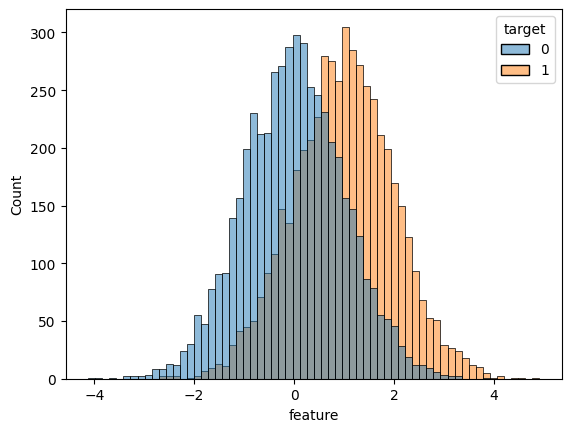

In [ ]:
sns.histplot(df, x = 'feature', hue = 'target')

In [ ]:
# запустите после того, как реализуете все функции
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

Сперва попробуем позапускать c меньшей дисперсией шума

In [ ]:
np.random.seed(89)

for noise_std in np.linspace(0.3, 1, num=5, endpoint=False):
  x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])

  display(woe_line(values=x, target=y, n_buckets=5))

Видим что с каждым шагом AUC и IV монотонно убывают; при этом изменения $R^2$ не столь ощутимы и не носят монотонный характер.

Посмотрим что будет происходить при увеличении дисперсии:

In [ ]:
for noise_std in np.linspace(2, 10, num=5, endpoint=False):
  x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])

  display(woe_line(values=x, target=y, n_buckets=5))

Как можно увидеть, AUC и IV все так же продолжают падать, но скорость убывания уже меньше (в силу того что сами значения уже достаточно малы); у $R^2$ так же начинает прослеживаться негативная динамика (так что при последней генерации WoE и вовсе перестал быть допустимо линейным)

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
# Вернем исходную выборку
np.random.seed(89)
noise_std = 1.
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])

woe_line(values=x**2, target=y, n_buckets=5)

В случае возведения в квадрат мы получаем одну крайне суровую проблему: признаки равных абсолютных значений, но разных знаков как бы "склеиваются"; как следствие, не обладая достаточными сведениями о природе признака, мы не можем наверняка говорить об отсутствии этого склеивания. По графику для наших данных лишь видно, что много значений концентрируются достаточно близко к нулю и имеется большой удаленный выброс; кроме того, легко заметить, что самая линия WoE перестала быть симметричной относительно пересечения с 0.

Я сомневаюсь, что может существовать какая-то универсальная обратная трансформация для этого случая. Единственное что могу предложить, это взять корень или логарифм для большей линейности модели (или попробовать применить ```clip``` для слишком удаленных правых значений)

In [ ]:
# Дает чуть больший R^2
woe_line(values=np.sqrt(x**2), target=y, n_buckets=5)

In [ ]:
# Еще лучше R^2
woe_line(values=(x**2).clip(0, 3), target=y, n_buckets=5)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

In [ ]:
woe_line(values=np.exp(x), target=y, n_buckets=5)

Можно присмотреться и увидеть, что прямая, соединяющая красные точки очень похожа на график функции логарифма; поэтому можно всегда попробовать взять ```np.log``` от данных, что приведет к увеличению линейности WoE

In [ ]:
woe_line(values=np.log1p(np.exp(x)), target=y, n_buckets=5)

## Часть 2. Строим ЛогРег.

В этом пунтке попробуем применить все наши навыки

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [ ]:
sns.set(style='darkgrid', palette='deep')
plt.rcParams['savefig.format'] = 'pdf'

In [ ]:
df = pd.read_csv('/content/risks-24-hw1.csv', index_col=0)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.417794,0.182394,-0.582374,0,-9.959913,-0.582374,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.009963,0.308079,6.889658,0,-4.517188,6.889658,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   100000 non-null  float64
 1   feature_2   100000 non-null  float64
 2   feature_3   100000 non-null  float64
 3   feature_4   100000 non-null  float64
 4   feature_5   100000 non-null  float64
 5   feature_6   100000 non-null  float64
 6   feature_7   100000 non-null  int64  
 7   feature_8   100000 non-null  float64
 8   feature_9   100000 non-null  float64
 9   feature_10  100000 non-null  float64
 10  feature_11  100000 non-null  float64
 11  feature_12  100000 non-null  float64
 12  feature_13  100000 non-null  float64
 13  feature_14  100000 non-null  float64
 14  feature_15  100000 non-null  object 
 15  d4p12       100000 non-null  int64  
dtypes: float64(13), int64(2), object(1)
memory usage: 13.0+ MB


Пропусков в признаках нет, форматы столбцов соответствуют заявленным

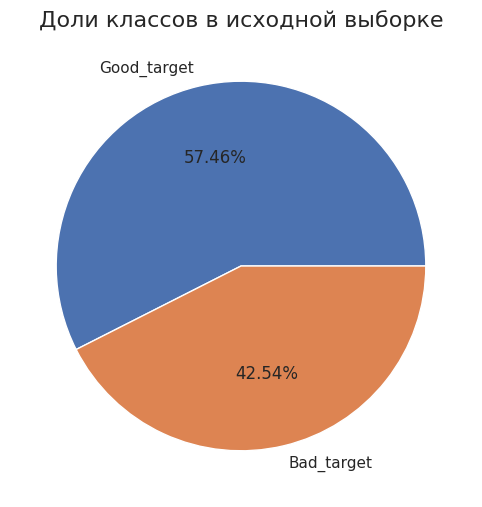

In [ ]:
plt.figure(figsize=(9,6))

plt.title("Доли классов в исходной выборке", fontsize=16)
plt.pie(df.d4p12.value_counts(), labels=['Good_target', 'Bad_target'],autopct="%0.2f%%")

plt.show()

Таргет по выборке распределен неравномерно, имеется небольшой перекос в класс 0

In [ ]:
df.loc[:, 'feature_1':'feature_14'].describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05
mean,-0.004065,-0.198827,-6.283870,-1.250730e-01,1.003480,2.973727,0.901520,-2.514795,2.973727,3.640370,-256.924907,1.013153,9.969348e+02,2.885691e-01
std,2.625003,169.576125,2344.152317,5.939374e-01,1.004035,3.998071,0.297964,5.009291,3.998071,4.977886,260.742462,2.314468,4.699415e+03,3.785086e-01
min,-54.598150,-38296.171946,-10000.000000,-1.999994e+00,0.000002,-16.569150,0.000000,-26.496544,-16.569150,-16.847030,-1012.820365,-9.210340,1.666947e-19,6.195140e-11
25%,-1.011666,-0.385200,-4.215224,-2.289926e-01,0.288478,0.281313,1.000000,-5.893561,0.281313,0.270052,-506.548930,-1.262413,3.451754e+00,1.371482e-03
50%,-0.058406,-0.072894,0.003200,-2.253828e-09,0.694669,2.971161,1.000000,-2.511154,2.971161,3.669848,-282.922772,-0.800022,2.341854e+01,4.439380e-02
75%,1.004057,0.395806,4.255211,1.127132e-01,1.389851,5.663969,1.000000,0.859395,5.663969,6.984301,-0.080408,3.344923,1.536384e+02,6.085319e-01
max,39.011329,20133.753873,10000.000000,9.999952e-01,12.006909,19.874766,1.000000,19.258719,19.874766,24.764462,446.685530,3.951220,3.729609e+05,1.000000e+00


In [ ]:
df.feature_7.value_counts()

1    90152
0     9848
Name: feature_7, dtype: int64

Размерности признаков сильно варьируются, некоторая стандартизация необходима. Во многих признаках явно видны выбросы с обеих сторон. Седьмой признак принимает только два значения, скорее всего его следует использовать в качестве категориального

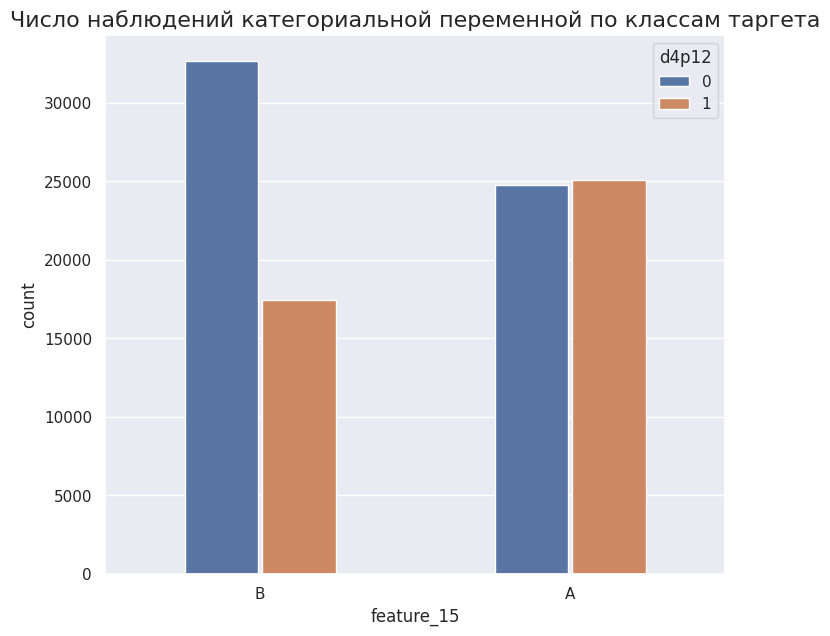

In [ ]:
plt.figure(figsize=(8,7))

sns.countplot(df, x="feature_15", hue="d4p12", width=.5, gap=.05)
plt.title("Число наблюдений категориальной переменной по классам таргета", fontsize=16)

plt.show()

In [ ]:
df.feature_15.value_counts()

B    50106
A    49894
Name: feature_15, dtype: int64

Распределение заявленного категорильного признака по классам неравномерно. В категории 'B' большой перекос идет в класс 0, в категории 'А' распределенность по классам примерно равная. Общее распределение по категориям практически равномерное

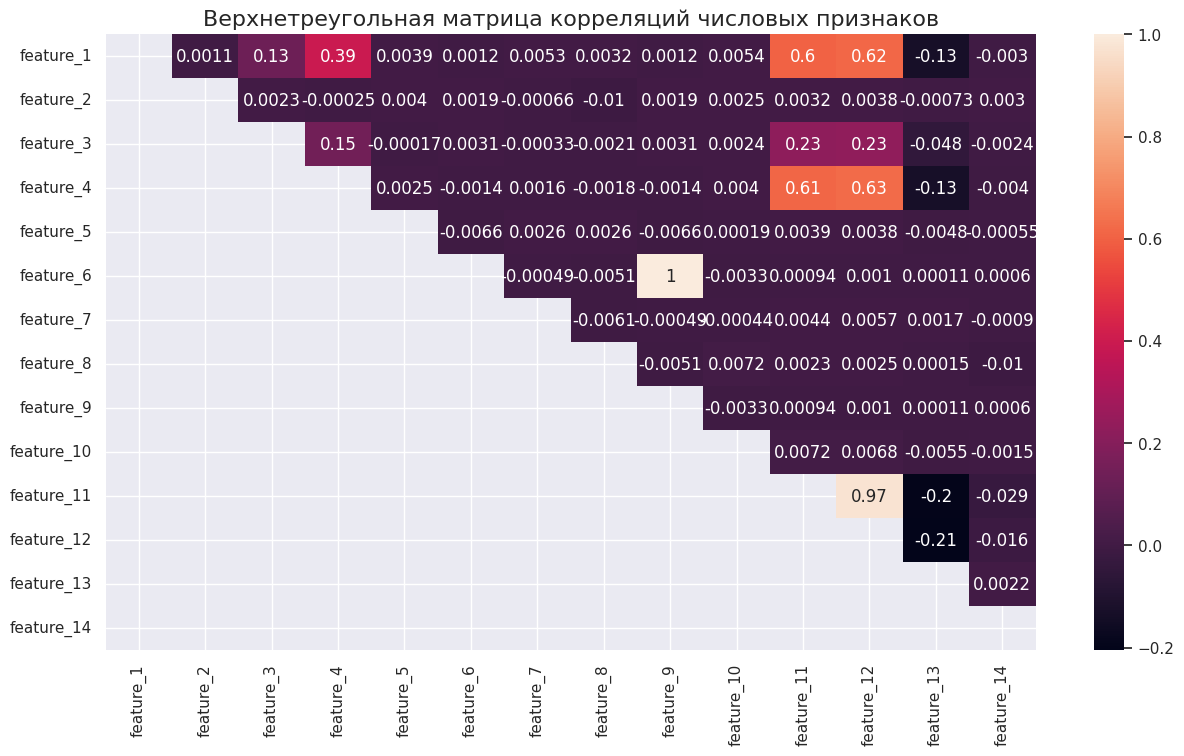

In [ ]:
correlations = df.loc[:,'feature_1':'feature_14'].corr()

sns.heatmap(correlations, annot=True, mask=np.tril(np.ones_like(correlations, dtype=bool)))
plt.title("Верхнетреугольная матрица корреляций числовых признаков", fontsize=16)

plt.show()

Очень большая корреляция между парами признаков feature_6 - feature_9 и feature_11 - feature_12; скорее всего следовало бы выбросить из датасета по одному из каждой пары. Также существенная корреляция наблюдается у feature_1 и feature_4 с признаками feature_11 и feature_12; может вызвать неприятные последствия в линейной модели. Остальные пары признаков скоррелированы слабо

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
y = df.d4p12
X = df.drop(columns=["d4p12"])

scaler = StandardScaler()
numeric_features = X.select_dtypes([np.number]).columns
X.loc[:,numeric_features] = scaler.fit_transform(X[numeric_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_base = LogisticRegression('l2').fit(X_train[numeric_features], y_train)

In [ ]:
y_pred_test = model_base.predict_proba(X_test[numeric_features])[:, 1]
y_pred_train = model_base.predict_proba(X_train[numeric_features])[:, 1]

In [ ]:
woe_line(values=logit(y_pred_train), target=y_train, n_buckets=5)

In [ ]:
woe_line(values=logit(y_pred_test), target=y_test, n_buckets=5)

По графиками можно увидеть, что модель в целом получилась достаточно линейной; тем не менее, показатели AUC и IV достаточно слабые, причем и на ```train```, и на ```test```. Переобучение здесь вряд ли возможно

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = X.select_dtypes([object]).columns

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logreg', LogisticRegression('l2'))
])

model_developed = pipeline.fit(X_train, y_train)

In [ ]:
y_pred_test = model_developed.predict_proba(X_test)[:, 1]
y_pred_train = model_developed.predict_proba(X_train)[:, 1]

In [ ]:
woe_line(values=logit(y_pred_train), target=y_train, n_buckets=5)

In [ ]:
woe_line(values=logit(y_pred_test), target=y_test, n_buckets=5)

Можно заметить, что при добавлении категориального признака показатели AUC и IV значительно улучшились; линейность так же сохранилась. Переобучение так же не наблюдается

### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег).

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

Зададим маску для подвыборок

In [ ]:
mask_A = X['feature_15'] == "A"
mask_B = X['feature_15'] == "B"

X_A = X.loc[mask_A, 'feature_1':'feature_14']
y_A = y.loc[mask_A]

X_B = X.loc[mask_B, 'feature_1':'feature_14']
y_B = y.loc[mask_B]

#### Feature_1

In [ ]:
display(woe_line(values=X_A['feature_1'].values, target=y_A.values, n_buckets=5))
display(woe_line(values=-np.log(X_A['feature_1'].values), target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_1'].values, target=y_B.values, n_buckets=5))
display(woe_line(values=-np.log(-X_B['feature_1'].values), target=y_B.values, n_buckets=5))

Признак информативный и достаточно линейный, следовательно можно использовать в дальнейшем для обучения

####Feature_2

In [ ]:
display(woe_line(values=X_A['feature_2'].values, target=y_A.values, n_buckets=5))
display(woe_line(values=(-1 / X_A['feature_2'].values).clip(-1300, -900), target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_2'].values, target=y_B.values, n_buckets=5))
display(woe_line(values=(1 / X_B['feature_2'].values).clip(-500, 300), target=y_B.values, n_buckets=5))

Признак так же информативный и обладает неплохой линейностью, следовательно и его будем использовать далее

#### Feature_3

In [ ]:
display(woe_line(values=X_A['feature_3'].values, target=y_A.values, n_buckets=5))
display(woe_line(values=np.sqrt(X_A['feature_3'].values.clip(0, 0.02)), target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_3'].values, target=y_B.values, n_buckets=5))
display(woe_line(values=np.sqrt((-X_B['feature_3'].values + 0.005).clip(0, 0.005)), target=y_B.values, n_buckets=5))

Признак информативный и достаточно линейный, следовательно можно использовать в дальнейшем для обучения

#### Feature_4 (шум)

In [ ]:
display(woe_line(values=X_A['feature_4'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_4'].values, target=y_B.values, n_buckets=5))

Видим, что AUC почти никакой, и IV близок к нулевому (преобразованиями мы его явно не улучшим); следовательно признак шумовой и его можно отбросить

#### Feature_5 (шум)

<Axes: ylabel='Count'>

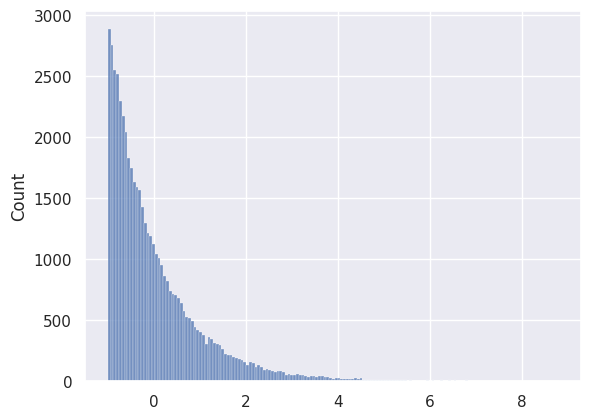

In [ ]:
sns.histplot(X_A['feature_5'].values)

In [ ]:
display(woe_line(values=X_A['feature_5'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_5'].values, target=y_B.values, n_buckets=5))

Снова AUC и IV слишком низкие, значит признак шумовой

#### Feature_6 (шум)

In [ ]:
display(woe_line(values=X_A['feature_6'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_6'].values, target=y_B.values, n_buckets=5))

Снова AUC и IV ни о чем, так что признак шумовой

#### Feature_7 (шум)

<Axes: ylabel='Count'>

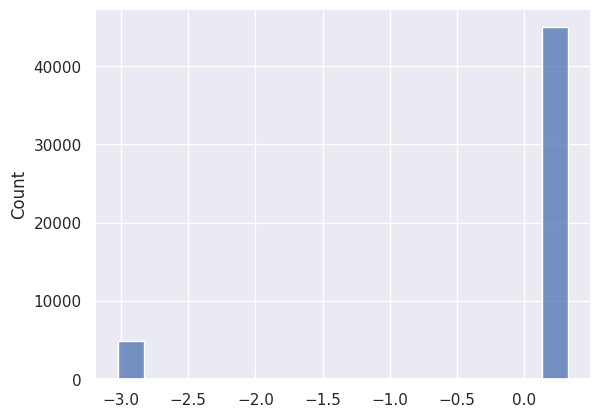

In [ ]:
sns.histplot(X_A['feature_7'].values)

In [ ]:
display(woe_line(values=X_A['feature_7'].values, target=y_A.values, n_buckets=min(5, X_A['feature_7'].nunique())))

In [ ]:
display(woe_line(values=X_B['feature_7'].values, target=y_B.values, n_buckets=min(5, X_A['feature_7'].nunique())))

Вообще ошибочно определенная числовая переменная (в EDA отмечался ее категориальный характер); AUC и IV опять говорят о том, что признак - всего лишь шум

#### Feature_8 (шум)

In [ ]:
display(woe_line(values=X_A['feature_8'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_8'].values, target=y_B.values, n_buckets=5))

Снова слишком близкий к случайному AUC и нулевой IV; вновь встретили шум

#### Feature_9 (шум)

In [ ]:
display(woe_line(values=X_A['feature_9'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_9'].values, target=y_B.values, n_buckets=5))

Забавный факт, но это просто копия *feature_9* (отсюда и коэффициент единица); так как оригинал был шумом, то и здесь то же шум

#### Feature_10 (шум)

<Axes: ylabel='Count'>

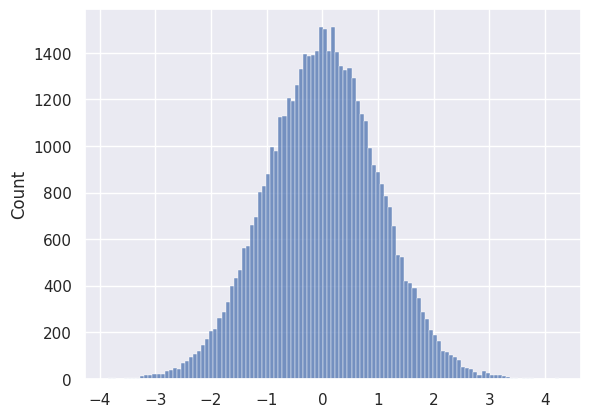

In [ ]:
sns.histplot(X_A['feature_10'].values)

In [ ]:
display(woe_line(values=X_A['feature_10'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_10'].values, target=y_B.values, n_buckets=5))

Уже в восьмой раз встречаем шум, ибо AUC и IV снова не впечатляют; отбросим признак

#### Feature_11

In [ ]:
display(woe_line(values=X_A['feature_11'].values, target=y_A.values, n_buckets=5))
display(woe_line(values=X_A['feature_11'].values.clip(0.9,1.1), target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_11'].values, target=y_B.values, n_buckets=5))
display(woe_line(values=X_B['feature_11'].values.clip(-1.1, -0.9), target=y_B.values, n_buckets=5))

Здесь наконец получили информативный признак, к тому же еще и достаточно сильный (особенно на подгруппе A). Будем его использовать в дальнейшем

#### Feature_12

In [ ]:
display(woe_line(values=X_A['feature_12'].values, target=y_A.values, n_buckets=30))
display(woe_line(values=X_A['feature_12'].values.clip(0.92,1.1), target=y_A.values, n_buckets=30))

In [ ]:
display(woe_line(values=X_B['feature_12'].values, target=y_B.values, n_buckets=5))

Снова информативный признак; не выбрасываем

#### Feature_13 (шум)

In [ ]:
display(woe_line(values=X_A['feature_13'].values, target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_13'].values, target=y_B.values, n_buckets=5))

Последний шум на сегодня (признаки все те же: AUC почти 0.5 и IV около нулевой)

#### Feature_14

In [ ]:
display(woe_line(values=X_A['feature_14'].values, target=y_A.values, n_buckets=5))
display(woe_line(values=-np.log1p(X_A['feature_14'].values).clip(-1, 1.4), target=y_A.values, n_buckets=5))

In [ ]:
display(woe_line(values=X_B['feature_14'].values, target=y_B.values, n_buckets=5))
display(woe_line(values=-np.log1p(X_B['feature_14'].values).clip(-1, 1.35), target=y_B.values, n_buckets=5))

Признак по показателям IV и AUC в целом неплохой и может быть использован, так что отбрасывать его не станем

#### Общая линеаризация

Из всего множества признаков линеаризовать успешно удалось только ```feature_1```

In [ ]:
display(woe_line(values=X['feature_1'].values, target=y.values, n_buckets=5))
display(woe_line(values=-np.log1p(np.sqrt(abs(X['feature_1'].values))), target=y.values, n_buckets=5))

Как мы видим, такая линеаризация приводит к существенным потерям разделяющей способности признака; кроме того, даже сама формула выглядит крайне громоздко, что является плохим сигналом о применимости преобразования.


Основное затрудение в общей линеаризации нешумовых признаков - существенные различия в распределении на каждом сегменте (по ```feature_15```)

Список "шумных" переменных:


*   *feature_4*
*   *feature_5*
*   *feature_6*
*   *feature_7*
*   *feature_8*
*   *feature_9*
*   *feature_10*
*   *feature_13*



In [ ]:
# Выкинем их из X
noise_columns = ['feature_4', 'feature_5', 'feature_6', 'feature_7',
                 'feature_8', 'feature_9', 'feature_10', 'feature_13']

X.drop(columns=noise_columns, inplace=True)

### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [ ]:
# преобразования по A
X.loc[mask_A, 'feature_1'] = -np.log(X.loc[mask_A, 'feature_1'])
X.loc[mask_A, 'feature_2'] = (-1 / X.loc[mask_A, 'feature_2']).clip(-1300, -900)
X.loc[mask_A, 'feature_3'] = np.sqrt(X.loc[mask_A, 'feature_3'].clip(0, 0.02))
X.loc[mask_A, 'feature_11'] = X.loc[mask_A, 'feature_11'].clip(0.9,1.1)
X.loc[mask_A, 'feature_12'] = X.loc[mask_A, 'feature_12'].clip(0.92,1.1)
X.loc[mask_A, 'feature_14'] = -np.log1p(X.loc[mask_A, 'feature_14']).clip(-1, 1.4)

In [ ]:
# преобразования по B
X.loc[mask_B, 'feature_1'] = -np.log(-X.loc[mask_B, 'feature_1'])
X.loc[mask_B, 'feature_2'] = (1 / X.loc[mask_B, 'feature_2']).clip(-500, 300)
X.loc[mask_B, 'feature_3'] = np.sqrt(X.loc[mask_B, 'feature_3'].clip(0, 0.02))
X.loc[mask_B, 'feature_11'] = X.loc[mask_B, 'feature_11'].clip(-1.1, -0.9)
X.loc[mask_B, 'feature_14'] = -np.log1p(X.loc[mask_B, 'feature_14']).clip(-1, 1.35)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# повторим сегментацию на трейне
mask_A = X_train['feature_15'] == "A"
mask_B = X_train['feature_15'] == "B"

X_train_A = X_train.loc[mask_A].drop(columns=['feature_15'])
y_train_A = y_train.loc[mask_A]

X_train_B = X_train.loc[mask_B].drop(columns=['feature_15'])
y_train_B = y_train.loc[mask_B]

# Обучим две модели
model_A = LogisticRegression().fit(X_train_A, y_train_A)
model_B = LogisticRegression().fit(X_train_B, y_train_B)

In [ ]:
# Запишем результаты предиктов на трейне в отдельную таблицу
predicts_train = pd.DataFrame(y_train)
predicts_train["proba"] = -1
predicts_train.loc[mask_A, "proba"] = model_A.predict_proba(X_train_A)[:, 1]
predicts_train.loc[mask_B, "proba"] = model_B.predict_proba(X_train_B)[:, 1]

woe_line(values=logit(predicts_train["proba"].values), target=predicts_train["d4p12"].values, n_buckets=5)

In [ ]:
# Повторим на тесте
mask_A = X_test['feature_15'] == "A"
mask_B = X_test['feature_15'] == "B"

predicts_test = pd.DataFrame(y_test)
predicts_test["proba"] = -1
predicts_test.loc[mask_A, "proba"] = model_A.predict_proba(X_test.loc[mask_A].drop(columns=['feature_15']))[:, 1]
predicts_test.loc[mask_B, "proba"] = model_B.predict_proba(X_test.loc[mask_B].drop(columns=['feature_15']))[:, 1]

woe_line(values=logit(predicts_test["proba"].values), target=predicts_test["d4p12"].values, n_buckets=5)

Еще раз улучшили модель (хотя не очень значительно, по сравнению со второй моделью). Если сопоставим с бейзлайном, то увидим, что IV увеличился практически в 5 (!) раз. AUC так же ощутимо возрос (с 0.7 до почти 0.9).

# Часть 3. Бонус.

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

Для разнообразия выведем левую часть из правой. Сперва вспомним, что y принимает только значения 0 и 1; тогда, по формуле полной вероятности для события $x_i$ получаем следующее:


$P(x_i)=P(x_i|y=1) + P(x_i|y=0)$

Используя теорему Байеса, выразим числитель и знаменатель уменьшаемого в правой части (учитывая формулу полной вероятности):

$P(y=1|x_i)$ = $P(x_i|y=1)P(y=1)\over P(x_i|y=1)P(y=1) + P(x_i|y=0)P(y=0)$

$P(y=0|x_i)$ = $P(x_i|y=0)P(y=0)\over P(x_i|y=1)P(y=1) + P(x_i|y=0)P(y=0)$

Видим, что знаменатили в обоих дробях сопадают, а значит при подставлении в правую часть они сократятся; тогда сделаем эту подстановку и проведем ряд элементарных преобразований:

$ln$($P(y=1|x_i)\over P(y=0|x_i)$) $-$ $ln$($P(y=1)\over P(y=0)$) = $ln$($P(x_i|y=1)P(y=1)\over P(x_i|y=0)P(y=0)$) $-$ $ln$($P(y=1)\over P(y=0)$) = $ln$($P(x_i|y=1)\over P(x_i|y=0)$*$P(y=1)\over P(y=0)$) $-$ $ln$($P(y=1)\over P(y=0)$) = $ln$($P(x_i|y=1)\over P(x_i|y=0)$) +  $ln$($P(y=1)\over P(y=0)$) $-$ $ln$($P(y=1)\over P(y=0)$) = $ln$($P(x_i|y=1)\over P(x_i|y=0)$)

ч.т.д.

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

Сперва обозначим очевидную вещь, что $goodrate$ = $G\over B + G$ = $B + G - B\over B + G$ = $1 - badrate$; тогда можем преобразовать второй логарифм в формуле $WoE_i$:

$ln$($B\over G$) = $ln$(${B\over B+G}\over {G\over B+G}$) = $ln$($badrate\over 1 - badrate$) = $logit(badrate)$ - по определению $logit$

Применяя аналогичные рассуждения для $badrate_i$ и $ln$(${B_i}\over {G_i}$) получаем, что $ln$(${B_i}\over {G_i}$) = $logit(badrate_i)$

Подстаим все в формулу для $WoE_i$:

$WoE_i(x_i)$ = $ln$(${B_i}\over {G_i}$) - $ln$($B\over G$) =  $logit(badrate_i)$ -  $logit(badrate)$

ч.т.д.

#### **Упражнение 3**

Пусть даны два дискретных распределения:

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





Как и в предыдущем упражнении, обозначим за $B$ общее кол-во дефолтников в выборке ($y = 1$), за $G$ - общее кол-во недефолтников в выборке ($y=0$), $B_i$ - кол-во дефолтников при $x_i$ значении признака, $G_i$ - кол-во недефолтников при $x_i$ значении признака. Тогда $B_i = P(x=x_i|y=1) * B = b_i * B$ и $G_i = P(x=x_i|y=0) * G = g_i * G$. Подставляя в формулы для дивергенции получаем:

$D_{KL}(B_x||G_x) = \sum_{j=1}^n b_j ln$(${b_j}\over {g_j}$) $= \sum_{j=1}^n $${b_j * B}\over {B}$$ln$(${b_j}\over {g_j}$) $= \sum_{j=1}^n $${B_j}\over {B}$$ln$(${b_j}\over {g_j}$)

Аналогично: $D_{KL}(B_x||G_x) = \sum_{j=1}^n $${G_j}\over {G}$$ln$(${g_j}\over {b_j}$)

Теперь распишем формулу для $IV_x$, используя преобразованные выражения:

$IV_x$ = $D_{KL}(B_x||G_x) + D_{KL}(B_x||G_x)$ = $\sum_{j=1}^n$(${B_j}\over {B}$ $-$ ${G_j}\over {G}$) $ln$(${b_j}\over {g_j}$)

Чтобы разобраться с логарифмом отношения, воспользуемся доказанным в первом упражнении:

$ln$(${b_j}\over {g_j}$) = $ln$(${P(x_i|y=1)}\over {P(x_i|y=0)}$) = $ln$($P(y=1|x_i)\over P(y=0|x_i)$) $-$ $ln$($P(y=1)\over P(y=0)$)

Домножим числитель и знаменатель обоих логарифмов на $N$ - кол-во клиентов, получим следующее:

$ln$(${g_j}\over {b_j}$) =  $ln$($P(y=1|x_i) * N\over P(y=0|x_i) * N$) $-$ $ln$($P(y=1) * N\over P(y=0) * N$) = $ln$($B_i\over G_i$) $-$ $ln$($B\over G$) = ${WoE}_i(x_i)$ - по определению $WoE$

Подставляя полученное в формулу выше, получаем выражение $IV_x$ через ${WoE}_i(x_i)$:

$IV_x$ = $\sum_{j=1}^n$(${B_j}\over {B}$ $-$ ${G_j}\over {G}$) ${WoE}_i(x_i)$